In [1]:
import os
import subprocess

import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
from copy import deepcopy
import torch.nn.functional as F
from sklearn import linear_model, model_selection
from sklearn.metrics import make_scorer, accuracy_score
from tqdm.notebook import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

from typing import Callable

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 
DEVICE

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Running on device: CUDA


'cuda'

In [2]:
torch.manual_seed(3047)

Gr = torch.Generator()
Gr.manual_seed(20)

Gf = torch.Generator()
Gf.manual_seed(30)

Gv = torch.Generator()
Gv.manual_seed(40)

In [3]:
# Mock setting

import logging
import requests
import tqdm
from torch.utils.data import Subset
from torchvision import transforms

USE_MOCK: bool = True

if USE_MOCK:
    logging.warning('Running with Mock')
    logging.warning('In this mode, internet access may be required.')

    # The number of checkpoints in this mode.
    # NOTE: 512 checkpoints are required in this competition.
    n_checkpoints = 10
    
    # The directory for a dataset and a pretrained model
    mock_dir = './mock'
    mock_model_path = os.path.join(mock_dir, "weights_resnet18_cifar10.pth")
    os.makedirs(mock_dir, exist_ok=True)

In [4]:

if DEVICE != 'cuda':
    raise RuntimeError('Make sure you have added an accelerator to your notebook; the submission will fail otherwise!')

In [5]:
local_path = "retrain_weights_resnet18_cifar10.pth"
if os.path.exists(local_path):
    os.remove(local_path)

In [6]:
response = requests.get("https://storage.googleapis.com/unlearning-challenge/" + local_path)
open(local_path, "wb").write(response.content)

44808169

In [7]:
weights_pretrained = torch.load(local_path, map_location=DEVICE)

# load model with pre-trained weights
rt_model = resnet18(weights=None, num_classes=10)
rt_model.load_state_dict(weights_pretrained)
rt_model.to(DEVICE)
rt_model.eval()

# print its accuracy on retain and forget set
# print(f"Retain set accuracy: {100.0 * accuracy(rt_model, retain_loader):0.1f}%")
# print(f"Forget set accuracy: {100.0 * accuracy(rt_model, forget_loader):0.1f}%")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)

# download the forget and retain index split
local_path = "forget_idx.npy"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/" + local_path
    )
    open(local_path, "wb").write(response.content)
forget_idx = np.load(local_path)

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=128, shuffle=True, num_workers=2
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=128, shuffle=True, num_workers=2, generator=RNG
)

100%|██████████| 170498071/170498071 [00:08<00:00, 20734850.71it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [9]:
from torch.optim.lr_scheduler import CosineAnnealingLR,CosineAnnealingWarmRestarts,StepLR
import torch.nn.init as init


def unlearning(
        net,
        retain_loader,
        forget_loader,
        val_loader,
):
    """Unlearning when forget set is not available."""
    last_layer = net.fc

    # Reset the parameters of the last layer
    if hasattr(last_layer, 'weight'):
        init.xavier_uniform_(last_layer.weight)
    if hasattr(last_layer, 'bias'):
        init.zeros_(last_layer.bias)
    
    epochs = 10
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    net.train()
    for _ in range(20):
        for inputs, targets in retain_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    net.eval()
    
    return net

In [10]:
def evaluation(net, dataloader, criterion, device = 'cuda'): ##evaluation function
    net.eval()
    total_samp = 0
    total_acc = 0
    total_loss = 0.0
    for (images, labels) in dataloader:
        images, labels = images.to(device), labels.to(device)
        _pred = net(images)
        total_samp+=len(labels)
        #print(f'total_samp={total_samp}')
        loss = criterion(_pred, labels)
        total_loss += loss.item()
        total_acc+=(_pred.max(1)[1] == labels).float().sum().item()
        #print(f'total_acc={total_acc}')
    #print(f'total_sample={total_samp}')
    mean_loss = total_loss / len(dataloader)
    mean_acc = total_acc/total_samp
    print(f'loss={mean_loss}')
    print(f'acc={mean_acc}')
    return mean_acc, mean_loss

In [11]:
criterion = nn.CrossEntropyLoss()
# retain_loader, forget_loader, validation_loader = get_dataset(64)
print(f"Retain set accuracy: {100.0 * evaluation(rt_model, retain_loader, criterion)[0]:0.1f}%")
print(f"Forget set accuracy: {100.0 * evaluation(rt_model, forget_loader, criterion)[0]:0.1f}%")

loss=0.01812899909815645
acc=0.9952666666666666
Retain set accuracy: 99.5%
loss=0.47970084361732007
acc=0.882
Forget set accuracy: 88.2%


In [12]:
def compute_outputs(net, loader):
    """Auxiliary function to compute the logits for all datapoints.
    Does not shuffle the data, regardless of the loader.
    """

    # Make sure loader does not shuffle the data
    if isinstance(loader.sampler, torch.utils.data.sampler.RandomSampler):
        loader = DataLoader(
            loader.dataset, 
            batch_size=loader.batch_size, 
            shuffle=False, 
            num_workers=loader.num_workers)
    
    all_outputs = []
    all_targets = []
    
    for (inputs, targets) in loader:
#         inputs, targets = sample["image"],sample["age_group"]
        inputs, targets = inputs.to(DEVICE), targets.to("cpu")

        logits = net(inputs).detach().cpu().numpy() # (batch_size, num_classes)
        
        all_outputs.append(logits)
        all_targets.extend(targets)
        
    return np.array(all_targets), np.concatenate(all_outputs) # (len(loader.dataset), num_classes)
    

In [13]:
def cross_entropy_f(x, targets):
    # Convert NumPy array to PyTorch tensor
    x_tensor = torch.from_numpy(x)

    # Apply softmax to the model output
    x_softmax = F.softmax(x_tensor, dim=-1)

    # Convert targets to one-hot encoding
    targets_tensor = torch.from_numpy(targets)
    targets_one_hot = F.one_hot(targets_tensor, num_classes=x_tensor.shape[-1])

    # Avoiding NaN values in x
    x_tensor[torch.isnan(x_tensor)] = 0.0

    # Calculate cross-entropy loss for each example
    loss = -torch.sum(targets_one_hot * torch.log(x_softmax), dim=-1)

    # Convert the result back to a NumPy array if needed
    loss_np = loss.numpy()

    return loss_np

In [14]:
def false_positive_rate(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Computes the false positive rate (FPR)."""
    fp = np.sum(np.logical_and((y_pred == 1), (y_true == 0)))
    n = np.sum(y_true == 0)
    return fp / n


def false_negative_rate(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Computes the false negative rate (FNR)."""
    fn = np.sum(np.logical_and((y_pred == 0), (y_true == 1)))
    p = np.sum(y_true == 1)
    return fn / p


# The SCORING dictionary is used by sklearn's `cross_validate` function so that
# we record the FPR and FNR metrics of interest when doing cross validation
SCORING = {
    'false_positive_rate': make_scorer(false_positive_rate),
    'false_negative_rate': make_scorer(false_negative_rate)
}


def logistic_regression_attack(
        outputs_U, outputs_R, n_splits=2, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      outputs_U: numpy array of shape (N)
      outputs_R: numpy array of shape (N)
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      fpr, fnr : float * float
    """
    assert len(outputs_U) == len(outputs_R)
    
    samples = np.concatenate((outputs_R, outputs_U)).reshape((-1, 1))
    labels = np.array([0] * len(outputs_R) + [1] * len(outputs_U))

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    has_nan = np.isnan(samples).any()
#     print(has_nan)
    
    samples = np.nan_to_num(samples, nan=0)
    
    scores =  model_selection.cross_validate(
        attack_model, samples, labels, cv=cv, scoring=SCORING)
    
    fpr = np.mean(scores["test_false_positive_rate"])
    fnr = np.mean(scores["test_false_negative_rate"])
    
    return fpr, fnr

In [15]:
def compute_epsilon_s(fpr: list[float], fnr: list[float], delta: float) -> float:
    """Computes the privacy degree (epsilon) of a particular forget set example, 
    given the FPRs and FNRs resulting from various attacks.
    
    The smaller epsilon is, the better the unlearning is.
    
    Args:
      fpr: list[float] of length m = num attacks. The FPRs for a particular example. 
      fnr: list[float] of length m = num attacks. The FNRs for a particular example.
      delta: float
    Returns:
      epsilon: float corresponding to the privacy degree of the particular example.
    """
    assert len(fpr) == len(fnr)
    
    per_attack_epsilon = [0.]
    for fpr_i, fnr_i in zip(fpr, fnr):
        if fpr_i == 0 and fnr_i == 0:
            per_attack_epsilon.append(np.inf)
        elif fpr_i == 0 or fnr_i == 0:
            pass # discard attack
        else:
            with np.errstate(invalid='ignore'):
                epsilon1 = np.log(1. - delta - fpr_i) - np.log(fnr_i)
                epsilon2 = np.log(1. - delta - fnr_i) - np.log(fpr_i)
            if np.isnan(epsilon1) and np.isnan(epsilon2):
                per_attack_epsilon.append(np.inf)
            else:
                per_attack_epsilon.append(np.nanmax([epsilon1, epsilon2]))
            
    return np.nanmax(per_attack_epsilon)


def bin_index_fn(
        epsilons: np.ndarray, 
        bin_width: float = 0.5, 
        B: int = 13
        ) -> np.ndarray:
    """The bin index function."""
    bins = np.arange(0, B) * bin_width
    return np.digitize(epsilons, bins)


def H(epsilons: np.ndarray) -> float:
    """Computes the forgetting quality given the privacy degrees 
    of the forget set examples.
    """
    ns = bin_index_fn(epsilons)
    hs = 2. / 2 ** ns
    return np.mean(hs)

In [16]:
def forgetting_quality(
        outputs_U: np.ndarray, # (N, S)
        outputs_R: np.ndarray, # (N, S)
        attacks: list[Callable] = [logistic_regression_attack],
        delta: float = 0.01
    ):
    """
    Both `outputs_U` and `outputs_R` are of numpy arrays of ndim 2:
    * 1st dimension coresponds to the number of samples obtained from the 
      distribution of each model (N=512 in the case of the competition's leaderboard) 
    * 2nd dimension corresponds to the number of samples in the forget set (S).
    """
    
    # N = number of model samples
    # S = number of forget samples
    N, S = outputs_U.shape
    
    assert outputs_U.shape == outputs_R.shape, \
        "unlearn and retrain outputs need to be of the same shape"
    
    epsilons = []
    pbar = tqdm(range(S))
    for sample_id in pbar:
        pbar.set_description("Computing F...")
        
        sample_fprs, sample_fnrs = [], []
        
        for attack in attacks: 
            uls = outputs_U[:, sample_id]
            rls = outputs_R[:, sample_id]
            
            fpr, fnr = attack(uls, rls)
            
            if isinstance(fpr, list):
                sample_fprs.extend(fpr)
                sample_fnrs.extend(fnr)
            else:
                sample_fprs.append(fpr)
                sample_fnrs.append(fnr)
        
        sample_epsilon = compute_epsilon_s(sample_fprs, sample_fnrs, delta=delta)
        epsilons.append(sample_epsilon)
        
    return H(np.array(epsilons))

In [17]:
n_checkpoints

10

In [18]:
## This snippet is provided by the organizers of kaggle competition as a startup script.

attacks = [logistic_regression_attack]
criterion = nn.CrossEntropyLoss()
outputs_U = []
outputs_R = []
retain_accuracy = []
test_accuracy = []
forget_accuracy = []

import numpy as np
if USE_MOCK:
    
    # NOTE: Almost same as the original codes
    
    # Download
    if not os.path.exists(mock_model_path):
        response = requests.get("https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth")
        open(mock_model_path, "wb").write(response.content)    
    
    os.makedirs('/kaggle/tmp', exist_ok=True)
#     retain_loader, forget_loader, validation_loader = get_dataset(64)
    net = resnet18(weights=None, num_classes=10)
    net.to(DEVICE)
    net.load_state_dict(torch.load(mock_model_path))
    u_model = deepcopy(net)
    for i in tqdm.trange(n_checkpoints):
        net.load_state_dict(torch.load(mock_model_path))
        print("I am unlearning all the wrong things you taught me")
        u_model = unlearning(net, retain_loader, forget_loader, val_loader)
        state = u_model.state_dict()
        torch.save(state, f'/kaggle/tmp/unlearned_checkpoint_{i}.pth')
        
        targets, outputs_Ui = compute_outputs(u_model, forget_loader)
        
        outputs_U.append( cross_entropy_f(outputs_Ui, targets) )
        
        print("Computing retain accuracy on Unlearning Model")
        acc, _ = evaluation(u_model, retain_loader, criterion)
        print("Retain accuracy on Unlearning Model is ",acc)
        retain_accuracy.append(acc)
        
        print("Computing test accuracy on Unlearning model")
        acc,_ = evaluation(u_model, val_loader, criterion)
        print("Test accuracy on Unlearning model is ", acc)
        test_accuracy.append(acc)
        
        print("Computing forget accuracy on Unlearning model")
        acc,_ = evaluation(u_model, forget_loader, criterion)
        print("Forget accuracy on Unlearning model is ",acc)
        forget_accuracy.append(acc)
    
    outputs_U = np.array(outputs_U)
    print("Printing outputs_U shape ",outputs_U.shape)
    
    assert outputs_U.shape == (n_checkpoints, len(forget_loader.dataset)),\
        "Wrong shape for outputs_U. Should be (num_model_samples, num_forget_datapoints)."
    
    
    RAR, _ = evaluation(rt_model, retain_loader, criterion)
    TAR, _ = evaluation(rt_model, val_loader, criterion)
    FAR, _ = evaluation(rt_model, forget_loader, criterion)
    
    RAU = np.mean(retain_accuracy)
    TAU = np.mean(test_accuracy)
    FAU = np.mean(forget_accuracy)
    
    RA_ratio = RAU / RAR
    TA_ratio = TAU / TAR
    
    for i in range(n_checkpoints):
        targets, outputs_Ri = compute_outputs(rt_model, forget_loader) #(len(forget_loader.dataset), 10) 
        
        outputs_R.append(cross_entropy_f(outputs_Ri, targets) )
    
    outputs_R = np.array(outputs_R)
    print("Printing outputs_R shape ",outputs_R.shape)
    

    
    # Ensure that submission.zip will contain exactly 512 checkpoints 
    # (if this is not the case, an exception will be thrown).
    unlearned_ckpts = os.listdir('/kaggle/tmp')
    if len(unlearned_ckpts) != n_checkpoints:
        raise RuntimeError('Expected exactly 512 checkpoints. The submission will throw an exception otherwise.')

    subprocess.run('zip submission.zip /kaggle/tmp/*.pth', shell=True)
    
    
else:
    print("Hi")

  0%|          | 0/10 [00:00<?, ?it/s]

I am unlearning all the wrong things you taught me
Computing retain accuracy on Unlearning Model
loss=0.4117215863344344
acc=0.8637777777777778
Retain accuracy on Unlearning Model is  0.8637777777777778
Computing test accuracy on Unlearning model
loss=0.8101002618670463
acc=0.746
Test accuracy on Unlearning model is  0.746
Computing forget accuracy on Unlearning model


 10%|█         | 1/10 [07:12<1:04:50, 432.33s/it]

loss=0.7848618656396866
acc=0.746
Forget accuracy on Unlearning model is  0.746
I am unlearning all the wrong things you taught me
Computing retain accuracy on Unlearning Model
loss=0.38141013914719224
acc=0.8698222222222223
Retain accuracy on Unlearning Model is  0.8698222222222223
Computing test accuracy on Unlearning model
loss=0.8473843574523926
acc=0.7498
Test accuracy on Unlearning model is  0.7498
Computing forget accuracy on Unlearning model


 20%|██        | 2/10 [14:22<57:30, 431.34s/it]  

loss=0.7687845468521118
acc=0.769
Forget accuracy on Unlearning model is  0.769
I am unlearning all the wrong things you taught me
Computing retain accuracy on Unlearning Model
loss=0.430851962713694
acc=0.8512666666666666
Retain accuracy on Unlearning Model is  0.8512666666666666
Computing test accuracy on Unlearning model
loss=0.879515390098095
acc=0.7346
Test accuracy on Unlearning model is  0.7346
Computing forget accuracy on Unlearning model


 30%|███       | 3/10 [21:33<50:17, 431.03s/it]

loss=0.8250609546899795
acc=0.7416
Forget accuracy on Unlearning model is  0.7416
I am unlearning all the wrong things you taught me
Computing retain accuracy on Unlearning Model
loss=0.47267238211564044
acc=0.8389555555555556
Retain accuracy on Unlearning Model is  0.8389555555555556
Computing test accuracy on Unlearning model
loss=0.9243204340338707
acc=0.7206
Test accuracy on Unlearning model is  0.7206
Computing forget accuracy on Unlearning model


 40%|████      | 4/10 [28:43<43:04, 430.71s/it]

loss=0.8931516394019127
acc=0.725
Forget accuracy on Unlearning model is  0.725
I am unlearning all the wrong things you taught me
Computing retain accuracy on Unlearning Model
loss=0.38409213785251434
acc=0.8668
Retain accuracy on Unlearning Model is  0.8668
Computing test accuracy on Unlearning model
loss=0.7960723444819451
acc=0.746
Test accuracy on Unlearning model is  0.746
Computing forget accuracy on Unlearning model


 50%|█████     | 5/10 [35:54<35:53, 430.62s/it]

loss=0.78616102039814
acc=0.7544
Forget accuracy on Unlearning model is  0.7544
I am unlearning all the wrong things you taught me
Computing retain accuracy on Unlearning Model
loss=0.3409035447984934
acc=0.8844666666666666
Retain accuracy on Unlearning Model is  0.8844666666666666
Computing test accuracy on Unlearning model
loss=0.763615358620882
acc=0.7598
Test accuracy on Unlearning model is  0.7598
Computing forget accuracy on Unlearning model


 60%|██████    | 6/10 [43:04<28:42, 430.53s/it]

loss=0.7289835125207901
acc=0.7676
Forget accuracy on Unlearning model is  0.7676
I am unlearning all the wrong things you taught me
Computing retain accuracy on Unlearning Model
loss=0.3102499969218942
acc=0.8956888888888889
Retain accuracy on Unlearning Model is  0.8956888888888889
Computing test accuracy on Unlearning model
loss=0.6971668474376201
acc=0.775
Test accuracy on Unlearning model is  0.775
Computing forget accuracy on Unlearning model


 70%|███████   | 7/10 [50:15<21:31, 430.56s/it]

loss=0.6696898870170116
acc=0.776
Forget accuracy on Unlearning model is  0.776
I am unlearning all the wrong things you taught me
Computing retain accuracy on Unlearning Model
loss=0.3813527951609682
acc=0.8697333333333334
Retain accuracy on Unlearning Model is  0.8697333333333334
Computing test accuracy on Unlearning model
loss=0.7875475160777569
acc=0.7584
Test accuracy on Unlearning model is  0.7584
Computing forget accuracy on Unlearning model


 80%|████████  | 8/10 [57:26<14:21, 430.80s/it]

loss=0.7951481103897095
acc=0.756
Forget accuracy on Unlearning model is  0.756
I am unlearning all the wrong things you taught me
Computing retain accuracy on Unlearning Model
loss=0.31003206862475385
acc=0.8936444444444445
Retain accuracy on Unlearning Model is  0.8936444444444445
Computing test accuracy on Unlearning model
loss=0.707913613319397
acc=0.766
Test accuracy on Unlearning model is  0.766
Computing forget accuracy on Unlearning model


 90%|█████████ | 9/10 [1:04:37<07:10, 430.73s/it]

loss=0.668821121007204
acc=0.7814
Forget accuracy on Unlearning model is  0.7814
I am unlearning all the wrong things you taught me
Computing retain accuracy on Unlearning Model
loss=0.35277652846310625
acc=0.8842
Retain accuracy on Unlearning Model is  0.8842
Computing test accuracy on Unlearning model
loss=0.7466649368405343
acc=0.759
Test accuracy on Unlearning model is  0.759
Computing forget accuracy on Unlearning model


100%|██████████| 10/10 [1:11:45<00:00, 430.58s/it]

loss=0.749470628798008
acc=0.7656
Forget accuracy on Unlearning model is  0.7656
Printing outputs_U shape  (10, 5000)


loss=0.01813017491804203
acc=0.9952666666666666
loss=0.4761434979736805
acc=0.8798
loss=0.4539141930639744
acc=0.882
Printing outputs_R shape  (10, 5000)
  adding: kaggle/tmp/unlearned_checkpoint_0.pth (deflated 6%)
  adding: kaggle/tmp/unlearned_checkpoint_1.pth (deflated 6%)
  adding: kaggle/tmp/unlearned_checkpoint_2.pth (deflated 6%)
  adding: kaggle/tmp/unlearned_checkpoint_3.pth (deflated 6%)
  adding: kaggle/tmp/unlearned_checkpoint_4.pth (deflated 6%)
  adding: kaggle/tmp/unlearned_checkpoint_5.pth (deflated 6%)
  adding: kaggle/tmp/unlearned_checkpoint_6.pth (deflated 6%)
  adding: kaggle/tmp/unlearned_checkpoint_7.pth (deflated 6%)
  adding: kaggle/tmp/unlearned_checkpoint_8.pth (deflated 6%)
  adding: kaggle/tmp/unlearned_checkpoint_9.pth (deflated 6%)


In [19]:
type(net)

torchvision.models.resnet.ResNet

In [20]:
import math

# Assuming outputs_U is a Python list
has_nan = np.isnan(np.array(outputs_R)).any()
print(has_nan)

has_nan = np.isnan(np.array(outputs_U)).any()
print(has_nan)

False
False


In [21]:
import math

# Assuming outputs_U is a Python list
has_nan = any(math.isnan(x) for x in outputs_U if isinstance(x, (float, int)))
has_nan

False

In [22]:
samples = np.concatenate((outputs_R, outputs_U)).reshape((-1, 1))

In [23]:
has_nan = np.isnan(samples).any()
has_nan

False

In [24]:
from tqdm import tqdm

attacks = [logistic_regression_attack]

f = forgetting_quality(
outputs_U, 
outputs_R,
attacks=attacks,
delta=0.01)

ret = {
    "total_score": f * RA_ratio * TA_ratio,
    "F": f,
    "unlearn_retain_accuracy": RAU,
    "unlearn_test_accuracy": TAU, 
    "unlearn_forget_accuracy": FAU,
    "retrain_retain_accuracy": RAR,
    "retrain_test_accuracy": TAR, 
    "retrain_forget_accuracy": FAR,
    "retrain_outputs": outputs_R,
    "unlearn_outputs": outputs_U,
    "unlearning_model": u_model
}

Computing F...: 100%|██████████| 5000/5000 [00:37<00:00, 132.67it/s]


In [25]:
ret

{'total_score': 0.39756059585076337,
 'F': 0.531314453125,
 'unlearn_retain_accuracy': 0.8718355555555556,
 'unlearn_test_accuracy': 0.75152,
 'unlearn_forget_accuracy': 0.75826,
 'retrain_retain_accuracy': 0.9952666666666666,
 'retrain_test_accuracy': 0.8798,
 'retrain_forget_accuracy': 0.882,
 'retrain_outputs': array([[1.1427237e+00, 6.8271221e-03, 5.4480130e-05, ..., 1.4155446e-01,
         4.6083200e-01, 2.1786564e-03],
        [1.1427237e+00, 6.8271221e-03, 5.4480130e-05, ..., 1.4155446e-01,
         4.6083200e-01, 2.1786564e-03],
        [1.1427237e+00, 6.8271221e-03, 5.4480130e-05, ..., 1.4155446e-01,
         4.6083200e-01, 2.1786564e-03],
        ...,
        [1.1427237e+00, 6.8271221e-03, 5.4480130e-05, ..., 1.4155446e-01,
         4.6083200e-01, 2.1786564e-03],
        [1.1427237e+00, 6.8271221e-03, 5.4480130e-05, ..., 1.4155446e-01,
         4.6083200e-01, 2.1786564e-03],
        [1.1427237e+00, 6.8271221e-03, 5.4480130e-05, ..., 1.4155446e-01,
         4.6083200e-01, 2.17

In [26]:
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


ut_train_losses = compute_losses(u_model, train_loader)
ut_test_losses = compute_losses(u_model, test_loader)
ut_forget_losses = compute_losses(u_model, forget_loader)

In [27]:
rt_train_losses = compute_losses(rt_model, train_loader)
rt_test_losses = compute_losses(rt_model, test_loader)
rt_forget_losses = compute_losses(rt_model, forget_loader)

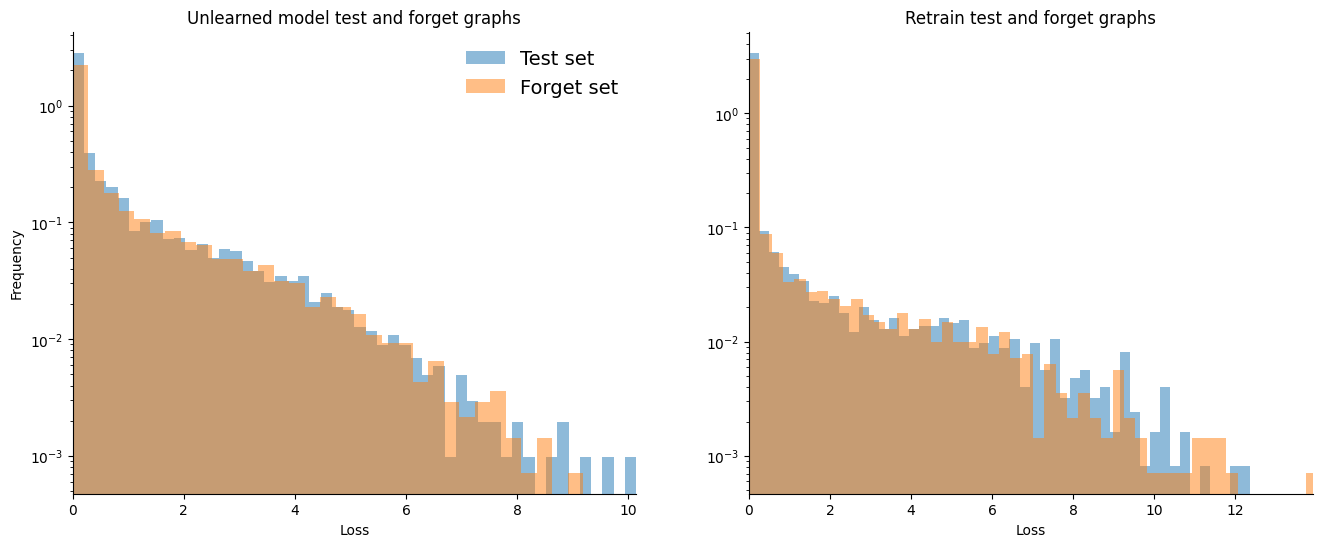

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Unlearned model test and forget graphs")
ax1.hist(ut_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(ut_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Retrain test and forget graphs"
)
ax2.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(ut_test_losses)))
ax2.set_xlim((0, np.max(ut_forget_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

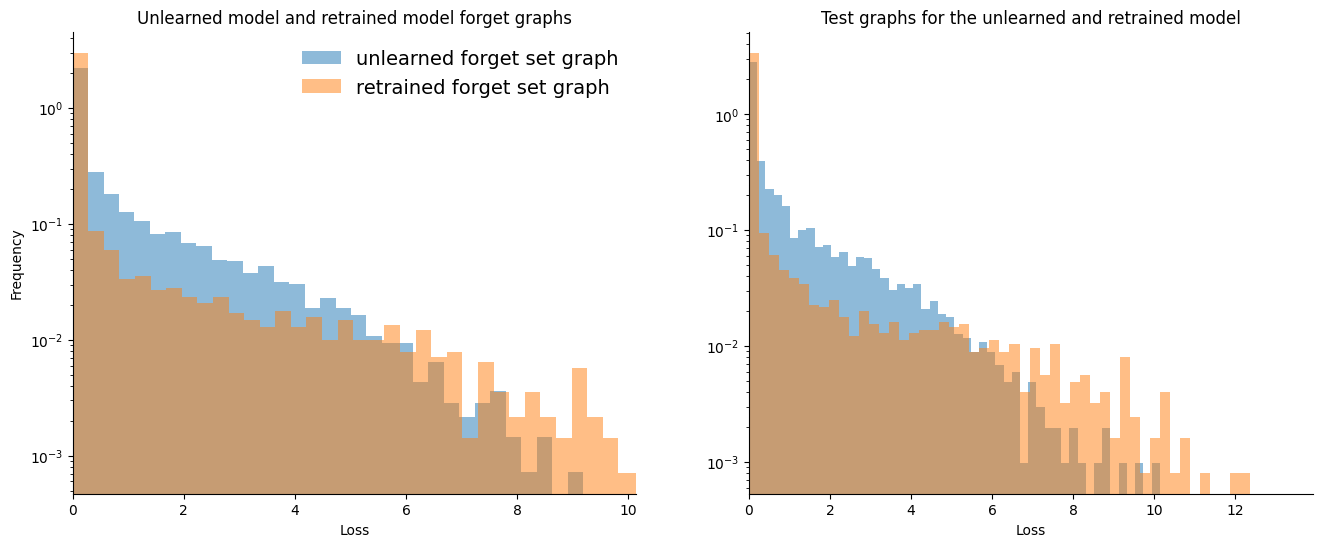

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Unlearned model and retrained model forget graphs")
ax1.hist(ut_forget_losses, density=True, alpha=0.5, bins=50, label="unlearned forget set graph")
ax1.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="retrained forget set graph")

ax2.set_title(
    f"Test graphs for the unlearned and retrained model"
)
ax2.hist(ut_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(ut_test_losses)))
ax2.set_xlim((0, np.max(ut_forget_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

In [30]:
print(torch.__version__)

2.0.0
